#Initialisation and downloading

##Packages and modules

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!pip install fasttext
!pip install transformers

Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 1.6MB 8.2MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 58 kB 3.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=ed94bb94c1755c617ee4e2736f68808606bac069ec43805a1c618817c35b922a
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
  distutils: /usr/

In [ ]:
import shutil
import os
import random
from shutil import move
from shutil import copy
from tqdm.notebook import tqdm
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
import fasttext.util
from nltk.tokenize import TweetTokenizer
from functools import reduce
from operator import add
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from google.colab import files
from google.colab import drive
import gzip
import zipfile
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.cm as cm
import plotly
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


##Downloading Datasets

In [ ]:
os.chdir('../content')
# upload the kaggle API file kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#downloading dataset

os.environ['KAGGLE_CONFIG_DIR'] = "/content" # kaggle.json has to be in the content directory
!kaggle datasets download -d gpreda/pfizer-vaccine-tweets

#unziping dataset

with zipfile.ZipFile("pfizer-vaccine-tweets.zip","r") as zip_ref:
        zip_ref.extractall("pfizer-vaccine-tweets/")
print("done")


  0% 0.00/1.30M [00:00<?, ?B/s]
100% 1.30M/1.30M [00:00<00:00, 162MB/s]
done


In [ ]:
#extracting UCI dataset, put manually .zip data in /content

import zipfile
with zipfile.ZipFile("sentiment-labelled-sentences.zip","r") as zip_ref:
        zip_ref.extractall("sentiment-labelled-sentences/")
print("done")

done


In [ ]:
#putting UCI into DataFrame
uci_data=pd.read_csv('sentiment-labelled-sentences/sentiment labelled sentences/amazon_cells_labelled.txt', delimiter = "\t")
uci_data.columns=['text','label']

##Downloading FastText

In [ ]:
#mounting google drive where FastText is
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#copying fasttext into environment
shutil.copytree('/gdrive/MyDrive/fasttext','/fasttext')

'/fasttext'

In [ ]:
#unzip fasttext
os.chdir("../fasttext")
with gzip.open('cc.en.300.bin.gz', 'rb') as f_in:
    with open('cc.en.300.bin', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
os.chdir('../content')
print("done")

done


#Preprocessing and data exploration

For preprocessing, we used the following code : https://xiangyutang2.github.io/tweet-classification/

In [ ]:
#putting data into a dataframe
data=pd.read_csv("pfizer-vaccine-tweets/vaccination_tweets.csv")
df=data

In [ ]:
#Cleaning data (removing links, special symbols,...)
#tweet_proc will be the column of preproceesed tweets


df['tweet_proc'] = df['text'].str.replace(r'http(\S)+', r'')
df['tweet_proc'] = df['tweet_proc'].str.replace(r'http ...', r'')
df['tweet_proc'] = df['tweet_proc'].str.replace(r'http', r'')
df[df['tweet_proc'].str.contains(r'http')]
df['tweet_proc'] = df['tweet_proc'].str.replace(r'(RT|rt)[ ]@[ ][\S]+',r'')
df[df['tweet_proc'].str.contains(r'RT[ ]?@')]
df['tweet_proc'] = df['tweet_proc'].str.replace(r'@[\S]+',r'')
df['tweet_proc'] = [''.join([i if ord(i) < 128 else '' for i in text]) for text in df['tweet_proc']]
df['tweet_proc'] = df['tweet_proc'].str.replace(r'_[\S]?',r'')
df['tweet_proc'] = df['tweet_proc'].str.replace(r'&amp;?',r'and')
df['tweet_proc'] = df['tweet_proc'].str.replace(r'&lt;',r'<')
df['tweet_proc'] = df['tweet_proc'].str.replace(r'&gt;',r'>')
df['tweet_proc'] = df['tweet_proc'].str.replace(r'[ ]{2, }',r' ')
df['tweet_proc'] = df['tweet_proc'].str.replace(r'([\w\d]+)([^\w\d ]+)', r'\1 \2')
df['tweet_proc'] = df['tweet_proc'].str.replace(r'([^\w\d ]+)([\w\d]+)', r'\1 \2')
df['tweet_proc'] = df['tweet_proc'].str.lower()
df['tweet_proc'] = df['tweet_proc'].str.strip()
df['tweet_proc'] = df.tweet_proc.apply(lambda x:re.sub(r'#','',x))  #hashtags
df['tweet_proc'] = df.tweet_proc.apply(lambda x:' '.join(re.findall(r'\w+', x)))          #special characters

#Tokenisation and word cloud

In [ ]:
#tokenisation
preprocessed=df['tweet_proc']
tk=preprocessed.drop_duplicates().apply(TweetTokenizer().tokenize).array

In [ ]:
#example of tokenised tweet
tk[0]

['same',
 'folks',
 'said',
 'daikon',
 'paste',
 'could',
 'treat',
 'a',
 'cytokine',
 'storm',
 'pfizerbiontech']

In [ ]:
#dictionnary of tokens sorted by frequency
arr = reduce(add, tk)
hist=Counter(arr)
dic={k: v for k, v in sorted(hist.items(), reverse=True, key=lambda item: item[1])}
print(dic)

{'the': 5367, 'pfizerbiontech': 4168, 'vaccine': 3325, 'to': 2890, 'covid': 2802, 'of': 2755, 'and': 2146, '19': 1800, 'a': 1758, 'in': 1685, 'i': 1421, 'my': 1315, 'for': 1306, 'is': 1187, 'pfizer': 1160, 'dose': 1062, 'first': 920, 'you': 821, 'on': 768, 'this': 757, 'it': 698, 'have': 685, 'covidvaccine': 609, 'with': 604, 'today': 594, 'be': 585, 'vaccines': 581, 'that': 560, 'are': 546, 'at': 534, 'got': 531, 's': 504, 'from': 481, 'so': 474, 'after': 461, 'vaccination': 452, 'not': 429, 'has': 426, '2': 418, 'second': 414, 'as': 411, 'biontech': 410, 'had': 405, 'vaccinated': 399, 'get': 394, 'will': 386, 'just': 369, 'all': 359, 'we': 358, 'coronavirus': 345, 'pfizervaccine': 343, 'by': 342, 'people': 340, 'was': 335, 'moderna': 334, 'received': 334, 'who': 330, '1': 324, 'doses': 316, 'but': 313, '2nd': 312, 'one': 300, 'no': 289, 'now': 286, 'shot': 282, 'about': 273, 't': 270, 'thank': 267, 'can': 258, 'done': 256, 'what': 250, 'astrazeneca': 248, 'its': 248, '19vaccine': 244

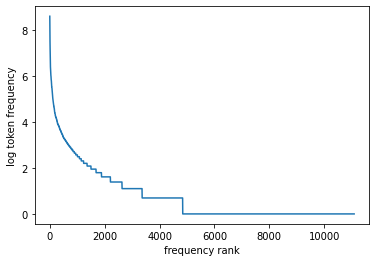

In [ ]:
#plotting log of token frequency in function of frequency rank, we recognise Zipf's law
plt.ylabel("log token frequency")
plt.xlabel("frequency rank")
plt.plot(np.log(sorted(Counter(arr).values(), reverse=True)))

In [ ]:
#removing short words
min_length=5

k=list(dic.keys())
for word in k:
  if len(word)<=min_length:
    dic.pop(word)

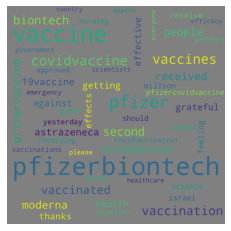

In [ ]:
#showing most frequent words
wc = WordCloud(background_color="grey",width=1000,height=1000, max_words=50,relative_scaling=0.4,normalize_plurals=False).generate_from_frequencies(dic)
plt.axis("off")
plt.imshow(wc)

#VADER

For this section, we used the following notebook : https://www.kaggle.com/thomaskonstantin/pfizer-vaccine-sentiment-and-time-series-analysis

In [ ]:
#downloading vader_lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sid=SIA()
df['sentiments']           = df['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

#creating a column for each sentiment
df['Positive Sentiment']   = df['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
df['Neutral Sentiment']    = df['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
df['Negative Sentiment']   = df['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

df.drop(columns=['sentiments'],inplace=True)

In [ ]:
#One hot encoding of sentiments 

seuil=0.2

df["Positive"]=(df['Positive Sentiment']-df['Negative Sentiment'])>seuil
df["Negative"]=(df['Negative Sentiment']-df['Positive Sentiment'])>seuil
df["Neutral"]=abs(df['Positive Sentiment']-df['Negative Sentiment'])<=seuil

In [ ]:
#example of negative tweet
num=225  #index among negative tweets
df.iloc[np.where(df["Negative"])[0][num]]['tweet_proc']

'is a cancer vaccine next pfizer pfizerbiontech'

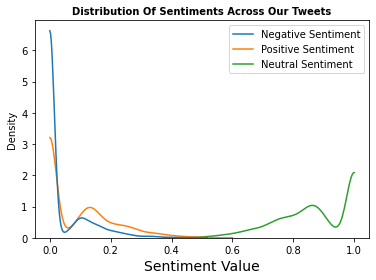

In [ ]:
#plotting sentiment probabilities

plt.title('Distribution Of Sentiments Across Our Tweets',fontsize=10,fontweight='bold')
sns.kdeplot(data=df[['Negative Sentiment','Positive Sentiment','Neutral Sentiment']],bw_method=0.2,cut=0)
plt.xlabel('Sentiment Value',fontsize=14)
plt.show()

#FASTTEXT

##Loading and example of FastText

In [ ]:
#installing and loading fasttext
ft = fasttext.load_model('../fasttext/cc.en.300.bin')

In [ ]:
#embedding vectors dimension selection
fasttext.util.reduce_model(ft, 100)

In [ ]:
#example of FastText embedding
ft.get_sentence_vector('hello everyone')

array([ 0.05449126, -0.08442509, -0.03012994, -0.23106483,  0.26906475,
       -0.04009903, -0.10969584, -0.09029561, -0.2769035 ,  0.01964655,
       -0.12995091,  0.02575199, -0.13110897, -0.02634917, -0.04991212,
        0.1008832 ,  0.04807445,  0.03079507,  0.01015981, -0.04643927,
        0.03984559,  0.08637447, -0.05657233,  0.05088425,  0.05709257,
        0.01795746, -0.10901593,  0.00035148, -0.11286032,  0.13266128,
        0.04610125,  0.05207125,  0.00507112,  0.06556405, -0.06869886,
        0.01090307,  0.03424999,  0.0573659 ,  0.00968141,  0.02333516,
        0.08946341,  0.03301349, -0.09767807,  0.04737591,  0.07227203,
        0.14603844,  0.13600174, -0.10879179,  0.18932414,  0.01876042,
       -0.01819349, -0.08130379,  0.07369406, -0.13105144, -0.08058967,
        0.12150478,  0.04757788, -0.14436683,  0.02467476, -0.07154858,
        0.10836256, -0.03620496, -0.08354688, -0.03959652,  0.13475205,
       -0.01161532, -0.0258105 , -0.03200101,  0.08105679,  0.05

##K-Means on FastText

In [ ]:
#extracting embeddings
embeddings=np.concatenate([ft.get_sentence_vector(df['tweet_proc'].iloc[i]).reshape((1,100)) for i in range(len(df['tweet_proc']))])

In [ ]:
#Applying k-means

model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=embeddings)
cluster_center_0 = model.cluster_centers_[0]
cluster_center_1 = model.cluster_centers_[1]

In [ ]:
#printing tweets from one cluster

for i in range(50,60):

  idx=np.where(model.labels_ == 1)[0][i]
  print(df['tweet_proc'].iloc[idx])

where did the warpspeed money go if not to the covid pioneers pfizerbiontech and moderna asking for a friend griftertrump klan
how the pfizerbiontech vaccine works this article made a detailed explanation covid19
it is a new type of vaccine that man is so daft it hurts my ears listening to him the biggest question
did you actually read the global news article jagmeet this tweet embedded therein j
first u s covid 19 vaccinations today thank you to everyone stepping up and getting it covidvaccine
anitaquidangen a personal support worker in toronto became one of the first people in canada to receive a
the state is supposed to get 35 100 doses total of the pfizerbiontech vaccine this week the remained 30 225 will
ruh roh anita i also saw heard michelle rempel suggest during qp in the house
kfdms fox 4s is at baptist hospital getting a first hand look at where the pfizer covid 19 vacci
privileged be offered the pfizerbiontech vaccine i would encourage everyone to take it up itll help protec

##Comparing to Vader

In [ ]:
#creating a function to compute accuracy on Vader labels

def accuracy_2clust(labels_kmeans,labels_pos_vader,labels_neg_vader):
  neg_tot=len(labels_neg_vader)
  pos_tot=len(labels_pos_vader)

  compte_neg_clust0=0 #for each permutation of labels, we compute the accuracy for both Vader labels
  compte_neg_clust1=0

  compte_pos_clust0=0
  compte_pos_clust1=0

  for i in range(neg_tot):
    if labels_kmeans[labels_neg_vader[i]] == 0 : #first permutation (negative -> 0, positive -> 1 with 0 and 1 being KMeans clusters)
      compte_neg_clust0+=1
    else:
      compte_neg_clust1+=1 #second permutation (negative -> 1, positive -> 0)


  for i in range(pos_tot):
    if labels_kmeans[labels_pos_vader[i]] == 0 :
      compte_pos_clust0+=1 #second permutation (negative -> 1, positive -> 0)
    else:
      compte_pos_clust1+=1 #first permutation (negative -> 0, positive -> 1)


  return compte_neg_clust0/neg_tot,compte_pos_clust1/pos_tot,compte_neg_clust1/neg_tot,compte_pos_clust0/pos_tot


In [ ]:
accuracy_2clust(model.labels_,np.where(df["Positive"]==1)[0],np.where(df["Negative"]==1)[0])

(0.4818181818181818,
 0.757679180887372,
 0.5181818181818182,
 0.24232081911262798)

For the first label permutation, we get accuracies (0.62, 0.24) and (0.38, 0.76) for the second label permutation.

#BERT

For this section, we used the following article : https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

##Preparing BERT data

In [ ]:
#extractiong positive and negative tweets (according to Vader)

data_neg=df.iloc[np.where(df["Negative"]==1)]
data_neg['label']=[0]*len(data_neg)
data_pos=df.iloc[np.where(df["Positive"]==1)]
data_pos['label']=[1]*len(data_pos)
new_data=pd.concat([data_neg,data_pos])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
testing_set=df.iloc[np.where(df["Neutral"]==1)]["tweet_proc"] #getting Vader-unlabeled tweets
data_shuffled = new_data.sample(frac=1).reset_index(drop=True) #shuffling data

In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train,test,'DATA_COLUMN','LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'tweet_proc'
LABEL_COLUMN = 'label'

## Finetuning BERT on tweets (Vader 1300 labels)

In [ ]:
#downloading pretrained model and tokenizer
model_vader = TFBertForSequenceClassification.from_pretrained("bert-base-cased")
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#selecting train and test data
train=data_shuffled.iloc[0:1300]  #Vader-labeled tweets for train
test=data_shuffled.iloc[1300:1521]    #Vader-labeled tweets for test 

In [ ]:
#creating mini-batches

train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [ ]:
#finetuning model

model_vader.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('AUC')])

model_vader.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [ ]:
#Examples to predict from to qualitatively test 
pred_sentences=['Grateful to receive my first shot PfizerBioNTech, now I have a third leg','same folks who said that cytokine storm could be treated','vaccine is a 5G chip','Pfizer is a corrupt lab','pfizer vaccine now available']

In [ ]:
#Observing predictions (binary)

tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model_vader(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])

Grateful to receive my first shot PfizerBioNTech, now I have a third leg : 
 Positive
same folks who said that cytokine storm could be treated : 
 Positive
vaccine is a 5G chip : 
 Positive
Pfizer is a corrupt lab : 
 Negative
pfizer vaccine now available : 
 Positive


In [ ]:
#Observing predictions (probabilities)
tf_predictions

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[7.3725253e-04, 9.9926275e-01],
       [3.4437843e-03, 9.9655628e-01],
       [2.4172863e-02, 9.7582710e-01],
       [9.9108422e-01, 8.9157820e-03],
       [2.3569637e-03, 9.9764305e-01]], dtype=float32)>

## Finetuning BERT on UCI amazon cells (1000 labeled comments)

In [ ]:
#Downloading pretrained model and tokenizer
model_UCI = TFBertForSequenceClassification.from_pretrained("bert-base-cased")
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#selecting train and test data
train=uci_data[0:900]    #training uci data
test=uci_data[900:1000]   #test uci data

In [ ]:
#creating mini-batches
UCI_DATA_COLUMN='text'
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, UCI_DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [ ]:
#finetuning on amazon UCI data
model_UCI.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('AUC')])

model_UCI.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
     58/Unknown - 51s 469ms/step - loss: 0.5161 - AUC: 0.7361WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
58/58 [==============================] - 55s 539ms/step - loss: 0.5133 - AUC: 0.7381 - val_loss: 0.2231 - val_AUC: 0.9293
Epoch 2/2
58/58 [==============================] - 28s 480ms/step - loss: 0.0853 - AUC: 0.9758 - val_loss: 0.2352 - val_AUC: 0.9293


In [ ]:
#Examples to predict from to qualitatively test 
pred_sentences=['Grateful to receive my first shot PfizerBioNTech, now I have a third leg','same folks who said that cytokine storm could be treated','vaccine is a 5G chip','Pfizer is a corrupt lab','pfizer vaccine now available']

In [ ]:
#Observing predictions (binary)

tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model_UCI(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])

Grateful to receive my first shot PfizerBioNTech, now I have a third leg : 
 Negative
same folks who said that cytokine storm could be treated : 
 Negative
vaccine is a 5G chip : 
 Positive
Pfizer is a corrupt lab : 
 Negative
pfizer vaccine now available : 
 Negative


In [ ]:
#Observing predictions (probabilities)
tf_predictions

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.8320399 , 0.16796012],
       [0.99479926, 0.00520072],
       [0.20073782, 0.79926217],
       [0.9985305 , 0.0014695 ],
       [0.5642905 , 0.43570948]], dtype=float32)>

##Comparing the two models

In [ ]:
#preparing label lists from the 2 models
tf_batch = tokenizer(list(np.asarray(testing_set))[0:1000], max_length=128, padding=True, truncation=True, return_tensors='tf')

tf_outputs_VADER = model_vader(tf_batch)
tf_outputs_UCI = model_UCI(tf_batch)

tf_predictions_VADER = tf.nn.softmax(tf_outputs_VADER[0], axis=-1)
tf_predictions_UCI = tf.nn.softmax(tf_outputs_UCI[0], axis=-1)

label_VADER= tf.argmax(tf_predictions_VADER, axis=1)
label_UCI= tf.argmax(tf_predictions_UCI, axis=1)

label_VADER = label_VADER.numpy()
label_UCI = label_UCI.numpy()

In [ ]:
#extracting indexes of tweets the 2 models do not agree on
desaccord=np.where(label_VADER != label_UCI)[0]

In [ ]:
testing_set[desaccord[60]]

'first u s covid 19 vaccinations today thank you to everyone stepping up and getting it covidvaccine'

In [ ]:
testing_set[desaccord[21]]

'vaccine trumpvaccine astrazeneca pfizerbiontech pfizervaccine pfizercovidvaccine pfizer s covid 19 belong'

In [ ]:
#Printing metrics to show differences between the 2 models (no ground truth is used here)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(label_VADER,label_UCI,target_names=['Negative','Positive']))
print(confusion_matrix(label_VADER,label_UCI))

              precision    recall  f1-score   support

    Negative       0.49      0.88      0.63       356
    Positive       0.88      0.49      0.63       644

    accuracy                           0.63      1000
   macro avg       0.69      0.69      0.63      1000
weighted avg       0.74      0.63      0.63      1000

[[314  42]
 [326 318]]
